In [38]:
import pandas as pd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [ ]:


def compute_rainfall_index(df, baseline_start='2000-01-01', baseline_end='2010-12-31'):
    """
    Compute 12-month Rainfall Index (RI) as percentile relative to baseline period.

    Parameters
    ----------
    df : pd.DataFrame
        Must have 'daily_rain' column and datetime index
    baseline_start : str
        Start date of baseline (inclusive)
    baseline_end : str
        End date of baseline (inclusive)

    Returns
    -------
    pd.Series
        RI (0-100) for each date where 6-month rolling sum can be computed
    """

    # 1. compute 6-month rolling sum
    rain_12mo = df['daily_rain'].rolling(window=182, min_periods=182).sum()

    # 2. select baseline period
    baseline_mask = (df.index >= baseline_start) & (df.index <= baseline_end)
    baseline_12mo = rain_12mo[baseline_mask].dropna()

    # 3. compute percentile rank for each date
    def percentile_rank(value):
        return 100 * (baseline_12mo <= value).sum() / len(baseline_12mo)

    ri = rain_12mo.dropna().apply(percentile_rank)

    return ri

In [30]:
def load_silo_site(ncfile):
    ds = xr.open_dataset(ncfile)

    # Drop lat/lon dimensions (they are length 1)
    ds = ds.squeeze(drop=True)

    # Convert time to datetime
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Mask fill values
    for v in ds.data_vars:
        if '_FillValue' in ds[v].attrs:
            ds[v] = ds[v].where(ds[v] != ds[v].attrs['_FillValue'])

    return ds

In [31]:
SILO_path = "/Users/phelps/PhD/DATA/climate/SILO/processed/flux_sites"
ds_SILO = load_silo_site(f"{SILO_path}/wom_2000-2024.nc")

In [32]:
df_SILO = ds_SILO.to_dataframe().reset_index().set_index('time')

In [33]:
df_SILO.index = pd.to_datetime(df_SILO.index)

In [34]:
RI = compute_rainfall_index(df_SILO, baseline_start='2000-01-01', baseline_end='2010-12-31')

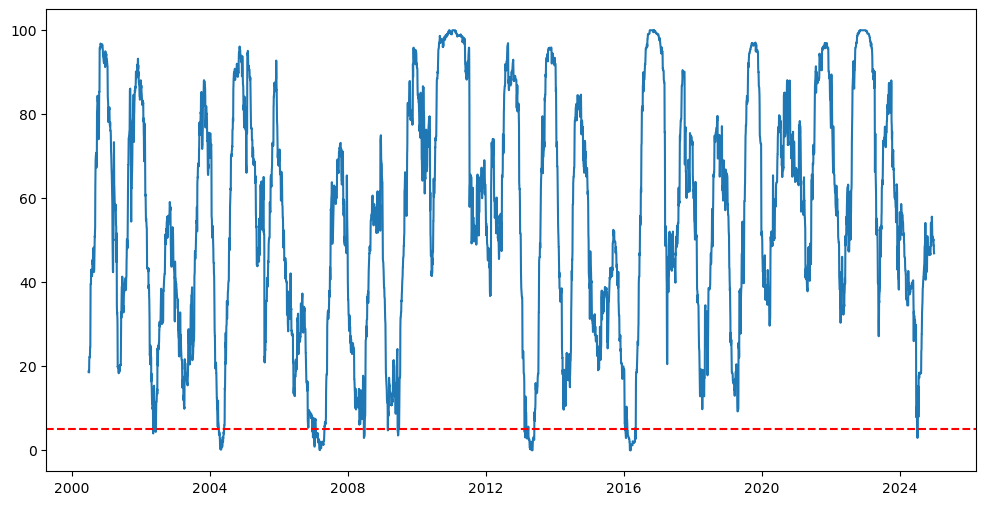

In [37]:

start_year = 2000
end_year = 2024

RI_subset = RI[(RI.index.year >= start_year) & (RI.index.year <= end_year)]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(RI_subset.index, RI_subset.values, label='Rainfall Index (RI)')

ax.axhline(5, color='red', linestyle='--', label='Drought Threshold (5th Percentile)')